In [87]:
# import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import uniform, randint

import tqdm
import xgboost
from xgboost import XGBClassifier

In [89]:
filepath = os.getcwd()

'/Users/kieranireland/Desktop/Sports Analytics/BigDataBowl2025'

In [90]:
player_play_file = os.path.join(filepath, "BigDataBowl2025/nfl-big-data-bowl-2025/player_play.csv")
games_file = os.path.join(filepath, "BigDataBowl2025/nfl-big-data-bowl-2025/games.csv")
players_file = os.path.join(filepath, "BigDataBowl2025/nfl-big-data-bowl-2025/players.csv")
plays_file = os.path.join(filepath, "BigDataBowl2025/nfl-big-data-bowl-2025/plays.csv")
motion_classes_file = os.path.join(filepath, "BigDataBowl2025/nfl-big-data-bowl-2025/motion_classes.csv")
tracking_files_train1 = [os.path.join(filepath, f"BigDataBowl2025/nfl-big-data-bowl-2025/tracking_week_{i}.csv") for i in range(1,4)]
tracking_files_train2 = [os.path.join(filepath, f"BigDataBowl2025/nfl-big-data-bowl-2025/tracking_week_{i}.csv") for i in range(4,7)]
tracking_files_train3 = [os.path.join(filepath, f"BigDataBowl2025/nfl-big-data-bowl-2025/tracking_week_{i}.csv") for i in range(7,9)]
tracking_files_test = [os.path.join(filepath, "BigDataBowl2025/nfl-big-data-bowl-2025/tracking_week_9.csv")]
full_tracking_files = [os.path.join(filepath, f"BigDataBowl2025/nfl-big-data-bowl-2025/tracking_week_{i}.csv") for i in range(1,10)]

In [91]:
players_play_df = pd.read_csv(player_play_file)
play_df = pd.read_csv(plays_file)
player_df = pd.read_csv(players_file)
games_df = pd.read_csv(games_file)
motion_class_df = pd.read_csv(motion_classes_file)

In [97]:
def combine_train_data(player_play_file, players_file, plays_file, tracking_files):
    
    plays_df = pd.read_csv(plays_file)
    player_play_df = pd.read_csv(player_play_file)
    games_df = pd.read_csv(games_file)
    players_df = pd.read_csv(players_file)
    players_df = players_df.drop(columns = 'displayName')
    
    tracking_df = pd.concat(
        [pd.read_csv(tracking_file) for tracking_file in tracking_files]
    )
    
    tmp_full_df1 = pd.merge(tracking_df, player_play_df, on=["gameId", "playId", "nflId"], how="left")
    tmp_full_df2 = pd.merge(tmp_full_df1, plays_df, on=["gameId", "playId"], how="left")
    full_df = pd.merge(tmp_full_df2, players_df, on=["nflId"], how="left")
    
    return full_df

In [98]:
def remove_unused_cols(df):
    
    used_cols = [
        "gameId", "playId", "nflId", "frameId", "frameType",
        "club", "possessionTeam", "defensiveTeam", "position", "jerseyNumber",
        "o_std", "a_std", "s_std", "x_std", "y_std", "dis_std", "dir_std", "los_std",
        "ballCarrierId", "offenseFormation", "receiverAlignment", "pff_manZone",
        "quarter", "down", "yardsToGo", "yardlineNumber", "absoluteYardlineNumber",
        "inMotionAtBallSnap", "shiftSinceLineset", "motionSinceLineset",
        "wasRunningRoute", "routeRan", "event"
    ]
    
    cols_to_drop = [col for col in df.columns if col not in used_cols]
    df = df.drop(columns = cols_to_drop)
    return df

In [99]:
def clean_data(df):
    
    ## STANDARDIZE THE DATA
    df["o_std"] = (-(df["o"] - 90)) % 360
    df["o_std"] = np.where(df["playDirection"] == "left", 180 - df["o"], df["o"])
    df["o_std"] = (df["o_std"] + 360) % 360
    
    
    df["dir_std"] = (-(df["dir"] - 90)) % 360
    df["dir_std"] = np.where(df["playDirection"] == "left", 180 - df["dir"], df["dir"])
    df["dir_std"] = (df["dir_std"] + 360) % 360
    
    df["x_std"] = np.where(df["playDirection"] == "left", 120-df["x"], df["x"])
    df["y_std"] = np.where(df["playDirection"] == "left", 160/3-df["y"], df["y"])
    df["s_std"] = df["s"]
    df["a_std"] = df["a"]
    df["dis_std"] = df["dis"]
    
    df['los_std'] = np.where(df['playDirection'] == 'left', 120-df['absoluteYardlineNumber'], df['absoluteYardlineNumber'])
    
    ## FILTER RUN/PASS
    df["isRun"] = pd.isna(df["passResult"]) | (df["passResult"] == "R")

    
    ## REMOVE RUN PLAYS, DATA POST-SNAP, AND NON-PENALTY PLAYS
    df = df[df["isRun"] == False]
    df = df[(df['event'] == 'man_in_motion') | (df['frameType'] == 'SNAP')]
#     df = df[(df['event'] == 'line_set') | (df["event"] == 'man_in_motion') | (df["frameType"] == "SNAP")]
    df = df[df.playNullifiedByPenalty != 'Y']
    df = df[df.quarter != 5]
    df = remove_unused_cols(df)

    
    return df

In [100]:
## GET X AND Y COORDS OF FOOTBALL
def get_ball_data(df):
    
    ball_df = df[df["club"] == "football"]
    ball_df = ball_df.rename(columns={"x_std":"x_ball", "y_std":"y_ball"})
    ball_df = ball_df.loc[:,['gameId', 'playId', 'frameId', 'club', 'x_ball', 'y_ball']].reset_index(drop=True)
    
    return ball_df

In [101]:
def get_offense_nums(df):
    
    qb_df = df[(df['position'] == 'QB') & (df['club'] == df['possessionTeam'])].groupby(['gameId', 'playId']).count().reset_index().rename(columns = {'position' : 'num_qbs'})[['gameId', 'playId', 'num_qbs']]
    
    rb_df = df[(df['position'] == 'RB') & (df['club'] == df['possessionTeam'])].groupby(['gameId', 'playId']).count().reset_index().rename(columns = {'position' : 'num_rbs'})[['gameId', 'playId', 'num_rbs']]
    
    wr_df = df[(df['position'] == 'WR') & (df['club'] == df['possessionTeam'])].groupby(['gameId', 'playId']).count().reset_index().rename(columns = {'position' : 'num_wrs'})[['gameId', 'playId', 'num_wrs']]
    
    te_df = df[(df['position'] == 'TE') & (df['club'] == df['possessionTeam'])].groupby(['gameId', 'playId']).count().reset_index().rename(columns = {'position' : 'num_tes'})[['gameId', 'playId', 'num_tes']]
    
    qb_rb_df = pd.merge(qb_df, rb_df, on=['gameId', 'playId'], how='left')
    non_wr_df = pd.merge(qb_rb_df, te_df, on=['gameId', 'playId'], how='left')
    offense_df = pd.merge(non_wr_df, wr_df, on=['gameId', 'playId'], how='left')
    
    return offense_df

In [102]:
def get_defense_nums(df):
    
    lb_positions = ['ILB', 'MLB']
    lb_df = df[(np.isin(df['position'], lb_positions)) & (df['club'] == df['defensiveTeam'])].groupby(['gameId', 'playId']).count().reset_index().rename(columns = {'position' : 'num_lbs'})[['gameId', 'playId', 'num_lbs']]
    
    db_positions = ['CB', 'FS', 'SS']
    db_df = df[(np.isin(df['position'], db_positions)) & (df['club'] == df['defensiveTeam'])].groupby(['gameId', 'playId']).count().reset_index().rename(columns = {'position' : 'num_dbs'})[['gameId', 'playId', 'num_dbs']]
    
    defense_df = pd.merge(lb_df, db_df, on=['gameId', 'playId'], how='left')
    
    return defense_df
    

In [103]:
def motion_wr_data(df):
    
#     df = df[(df['event'] == 'line_set') | (df['frameType'] == 'SNAP')]
    
    ## ONLY KEEP WRs RUNNING A ROUTE, WHO HAVE SHIFTED OR MOTIONED, AGAINST MAN COVERAGE
    df = df[df["wasRunningRoute"]==True]
    df = df[(df["motionSinceLineset"]==True) | (df["shiftSinceLineset"]==True)]
    df = df[df["position"]=="WR"]
    df = df[df["pff_manZone"]=="Man"]
    
    ## Calculating Delta of x,y,s,a,dir,o and Dist From LOS
    df['delta_x'] = df.groupby(['gameId', 'playId', 'nflId'])['x_std'].diff()
    df['delta_y'] = df.groupby(['gameId', 'playId', 'nflId'])['y_std'].diff()
    df['delta_s'] = df.groupby(['gameId', 'playId', 'nflId'])['s_std'].diff()
    df['delta_a'] = df.groupby(['gameId', 'playId', 'nflId'])['a_std'].diff()
    df['delta_dir'] = df.groupby(['gameId', 'playId', 'nflId'])['dir_std'].diff()
    df['delta_o'] = df.groupby(['gameId', 'playId', 'nflId'])['o_std'].diff()
    df['distFromLOS'] = df['los_std'] - df['x_std']
    
    df['numWRsLeft'] = int(df['receiverAlignment'].str.split(pat='x').iloc[0][0])
    df['numWRsRight'] = int(df['receiverAlignment'].str.split(pat='x').iloc[0][1])
    
    return df

In [104]:
def player_effect(players_play_df, play_df, player_df):
    full_player_df = pd.merge(players_play_df, play_df, on=['gameId', 'playId'], how='left')
    player_effect_df = pd.merge(full_player_df, player_df, on=['nflId'],how='left')
    player_effect_df = player_effect_df.loc[:, ['gameId', 'playId', 'nflId', 'displayName', 'position', 'teamAbbr', 'expectedPointsAdded',
                                            'pff_manZone', 'shiftSinceLineset', 'motionSinceLineset', 'wasRunningRoute']]

    player_effects = player_effect_df[
                            (player_effect_df.position == 'WR') 
                            & (player_effect_df.pff_manZone == 'Man')
                            & (player_effect_df.wasRunningRoute == 1.0)
                            & ((player_effect_df.motionSinceLineset == True) 
                                | (player_effect_df.shiftSinceLineset == True))]
    
    wr_motion_epa_play = pd.DataFrame(player_effects.groupby(['nflId'])['expectedPointsAdded'].mean())
    wr_motion_epa_play = wr_motion_epa_play.sort_values(by = ['expectedPointsAdded'], ascending=False)
    wr_motion_epa_play = pd.merge(wr_motion_epa_play, player_df[['nflId', 'displayName']], on='nflId', how='left')
    
    return wr_motion_epa_play

In [105]:
def nearest_def_dist(df):

    
    ## CHANGE TO BE NEAREST DEF AMONG DBs or LBs not down linemen
    def_positions = ['CB', 'DB', 'SS', 'FS', 'ILB', 'LB', 'MLB']
    
    conditions = [
        (df["club"] == "football"),
        (df["position"] == 'WR'),
        np.isin(df['position'], def_positions)
    ]
    choices = ["BALL", "WR", "DEF"]

    df["playerType"] = np.select(conditions, choices, "OFF")
    
    df = df[(df['frameType']=='SNAP')]
    df = df[['gameId', 'playId', 'nflId', 'playerType', 'x_std', 'y_std']]
    
    wr_df = df[(df['playerType'] == 'WR')]
    def_df = df[df['playerType'] == 'DEF']
    
    # Merge WRs with DEFs to compute distances between each WR and each DEF
    merged = pd.merge(wr_df, def_df, on=['gameId', 'playId'], suffixes=('_WR', '_DEF'), how='left')

    # Calculate the Euclidean distance between WR and DEF using vectorized operations
    merged['distance'] = np.sqrt((merged['x_std_DEF'] - merged['x_std_WR'])**2 + (merged['y_std_DEF'] - merged['y_std_WR'])**2)

    # For each WR, find the DEF with the minimum distance
    closest_def = merged.loc[merged.groupby(['gameId', 'playId', 'nflId_WR'])['distance'].idxmin()]

    # Select the relevant columns (WR's nflId, closest DEF's nflId, and the min distance)
    result = closest_def[['gameId', 'playId', 'nflId_WR', 'nflId_DEF', 'distance']].reset_index(drop=True)
    result['frameType'] = 'SNAP'

    # Rename columns for clarity
    result = result.rename(columns={'nflId_WR': 'nflId', 'nflId_DEF': 'nflId_closest_DEF', 'distance': 'min_def_distance'})    
    
    return result

In [106]:
def player_speed_effect(player_df, play_df, players_play_df,
                        tracking_files_train1, tracking_files_train2, tracking_files_train3):
    tracking_df1 = pd.concat(
        [pd.read_csv(tracking_file) for tracking_file in tracking_files_train1]
    )
    tracking_df2 = pd.concat(
        [pd.read_csv(tracking_file) for tracking_file in tracking_files_train2]
    )
    tracking_df3 = pd.concat(
        [pd.read_csv(tracking_file) for tracking_file in tracking_files_train3]
    )
    
    
    speed_files1 = tracking_df1[['gameId', 'playId', 'frameId', 'frameType', 'nflId', 'displayName', 's']]
    speed_files2 = tracking_df2[['gameId', 'playId', 'frameId', 'frameType', 'nflId', 'displayName', 's']]
    speed_files3 = tracking_df3[['gameId', 'playId', 'frameId', 'frameType', 'nflId', 'displayName', 's']]
    speed_files = pd.concat([speed_files1, speed_files2, speed_files3])
    speed_files = speed_files[speed_files["frameType"] == "AFTER_SNAP"]
    
    speed_players_file = player_df[['nflId', 'position']]
    speed_players_file = speed_players_file[speed_players_file["position"]=="WR"]
    
    speed_plays_file = play_df[['gameId', 'playId', 'passResult']]
    speed_plays_file["isRun"] = pd.isna(speed_plays_file["passResult"]) | (speed_plays_file["passResult"] == "R")
    speed_plays_file = speed_plays_file[speed_plays_file["isRun"] == False]
    
    speed_player_play_file = players_play_df[['gameId', 'playId', 'nflId', 'wasRunningRoute']]
    speed_player_play_file = speed_player_play_file[speed_player_play_file["wasRunningRoute"]==True]
    
    df = pd.merge(speed_files, speed_player_play_file, on=['gameId', 'playId', 'nflId'], how='inner')
    df = pd.merge(df, speed_plays_file, on=['gameId', 'playId'], how='inner')
    df = pd.merge(df, speed_players_file, on='nflId', how='inner')
      
    max_speed_df = pd.DataFrame(df.groupby(['nflId', 'displayName'], as_index=False)['s'].max())
    max_speed_df = max_speed_df.rename(columns = {'s': 'max_speed'})
    mean_speed_df = pd.DataFrame(df.groupby(['nflId', 'displayName'], as_index=False)['s'].mean())
    mean_speed_df = mean_speed_df.rename(columns = {'s': 'mean_speed'})
    speed_df = pd.merge(max_speed_df, mean_speed_df, on=['nflId', 'displayName'], how='left')
    
    return speed_df

In [107]:
def feature_creation(clean_df, wr_df, ball_df, nearest_def_df, player_effect_df, motionType_df, speed_df):
    
    
    ## GET BALL X AND Y COORDS
#     ball_df = clean_df[clean_df["club"] == "football"]
#     ball_df = ball_df.rename(columns={"x_std":"x_ball", "y_std":"y_ball"})
#     ball_df = ball_df.loc[:,['gameId', 'playId', 'frameId', 'x_ball', 'y_ball']].reset_index(drop=True)
    
    final_df = pd.merge(wr_df, ball_df, on=['gameId', 'playId', 'frameId'], how = 'left')
    final_df['distFromBall'] = final_df['y_ball'] - final_df['y_std']
    final_df['fieldSide'] = np.where(final_df['y_std'] >= final_df['y_ball'], 'left', 'right')
    final_df['fieldSide'] = np.where(final_df['y_std'] == final_df['y_ball'], 'center', final_df['fieldSide'])
    
    final_df = final_df[final_df.frameType == 'SNAP']
    
    train_df = pd.merge(final_df, nearest_def_df, on=['gameId', 'playId', 'nflId', 'frameType'], how='left')
    train_df = pd.merge(train_df, player_effect_df[['nflId', 'expectedPointsAdded']], on=['nflId'], how='left')
    train_df = pd.merge(train_df, speed_df[['nflId', 'max_speed', 'mean_speed']], on=['nflId'], how='left')
    train_df = pd.merge(train_df, motionType_df[['gameId', 'playId', 'nflId', 'motionType']],
                        on=['gameId', 'playId', 'nflId'], how='left')
    
    train_df['motionType'] = np.where(train_df.motionType.isnull(), 'other', train_df.motionType)
    train_df['offenseFormation'] = np.where(train_df.offenseFormation.isnull(), 'other', train_df.offenseFormation)
    
    
    return train_df

In [108]:
def combine_data(player_play_file, players_file, plays_file, tracking_files, motionType_df, speed_df):
    
    full_df = combine_train_data(player_play_file, players_file, plays_file, tracking_files)
    clean_df = clean_data(full_df)
    
    off_nums_df = get_offense_nums(clean_df)
    def_nums_df = get_defense_nums(clean_df)
    clean_df = pd.merge(clean_df, off_nums_df, on=['gameId', 'playId'], how='left')
    clean_df = pd.merge(clean_df, def_nums_df, on=['gameId', 'playId'], how='left')
    
    ball_df = get_ball_data(clean_df)
    nearest_def_df = nearest_def_dist(clean_df)
    wr_motion_df = motion_wr_data(clean_df)
    player_effect_df = player_effect(players_play_df, play_df, player_df)
    
    final_df = feature_creation(clean_df, wr_motion_df, ball_df, nearest_def_df,
                                player_effect_df, motionType_df, speed_df)
    
    return final_df

In [109]:
def final_train_cols(df):
    
    used_cols = [ 
        "gameId", 'playId', 'nflId', 'frameId', 'club',
        "o_std", "a_std", "s_std", "x_std", "y_std", "dir_std",
        "delta_o", "delta_a", "delta_s", "delta_x", "delta_y", "delta_dis", "delta_dir",
        "distFromLOS", 'distFromBall', 'mean_speed', "routeRan", 'min_def_distance', 'max_speed',
        "numWRsLeft", 'numWRsRight', "yardsToGo", "motionType_orig",
        'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', "down_1", 'down_2', 'down_3', 'down_4',
        "motionType_fly", "motionType_short", "motionType_jet", 
        "motionType_other", "motionType_orbit", "motionType_return",
        'num_qbs', 'num_rbs', 'num_wrs', 'num_tes', 'num_lbs', 'num_dbs', 
        'offenseFormation_orig', 'is_EMPTY', 'is_I_FORM', 'is_JUMBO',
        'is_PISTOL', 'is_SHOTGUN', 'is_SINGLEBACK', 'is_other',
        'is_2x1', 'is_2x2', 'is_3x1', 'is_3x2', 'is_4x1',
        "inMotionAtBallSnap", "los_std", "dis_std",  "wasRunningRoute",  'fieldSide'
    ]

    #  'expectedPointsAdded',
    cols_to_drop = [col for col in df.columns if col not in used_cols]
    df = df.drop(columns = cols_to_drop)
    return df

In [110]:
speed_df = player_speed_effect(player_df, play_df, players_play_df,
                        tracking_files_train1, tracking_files_train2, tracking_files_train3)
full_df1 = combine_data(player_play_file, players_file, plays_file, tracking_files_train1, motion_class_df, speed_df)
full_df2 = combine_data(player_play_file, players_file, plays_file, tracking_files_train2, motion_class_df, speed_df)
full_df3 = combine_data(player_play_file, players_file, plays_file, tracking_files_train3, motion_class_df, speed_df)

/var/folders/r5/6d27792j17n09czhhjvh9r3c0000gn/T/ipykernel_79205/3060520497.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speed_plays_file["isRun"] = pd.isna(speed_plays_file["passResult"]) | (speed_plays_file["passResult"] == "R")


In [111]:
full_df = pd.concat([full_df1, full_df2, full_df3])
full_df = full_df.rename(columns = {'club_x': 'club'})

In [21]:
# full_df_path = os.path.join(filepath, "BigDataBowl2025/nfl-big-data-bowl-2025/full_df_maninmotion.csv")
# full_df.to_csv(full_df_path)

In [114]:
full_df['motionType_orig'] = full_df['motionType']
full_df['offenseFormation_orig'] = full_df['offenseFormation']

final_data = pd.get_dummies(full_df, columns = ['motionType'])
final_data = pd.get_dummies(final_data, columns = ['offenseFormation', 'receiverAlignment'], prefix='is')
final_data = pd.get_dummies(final_data, columns = ['down', 'quarter'])

In [27]:
# final_motion_path = os.path.join(filepath, "BigDataBowl2025/nfl-big-data-bowl-2025/final_df_with_motion_mim.csv")
# final_data.to_csv(final_motion_path)

In [123]:
data = final_train_cols(final_data)
# test = final_train_cols(final_test)

refactorY = pd.factorize(data['routeRan'])
data['routeRefactor'] = refactorY[0]

refactorMotion = pd.factorize(data['motionType_orig'])
data['motionRefactor'] = refactorMotion[0]

refactorFormation = pd.factorize(data['offenseFormation_orig'])
data['formationRefactor'] = refactorFormation[0]

data['inMotionAtBallSnap'].replace([True, False], [1,0], inplace=True)
data['fieldSide'].replace(['right', 'left'], [1,0], inplace=True)

X = data.drop(columns = ['routeRan', 'wasRunningRoute', 'routeRefactor'])

y = data.routeRefactor

X_train, X_test, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=42)

train_x = X_train.drop(columns = ['gameId', 'playId', 'nflId', 'frameId', 'club', 'max_speed',
                         "motionType_orig", "max_speed", 'offenseFormation_orig',
                         'num_qbs', 'fieldSide', 'motionRefactor', 'formationRefactor'])

test_x = X_test.drop(columns = ['gameId', 'playId', 'nflId', 'frameId', 'club', 'max_speed',
                         "motionType_orig", "max_speed", 'offenseFormation_orig',
                         'num_qbs', 'fieldSide', 'motionRefactor', 'formationRefactor'])

In [79]:
# ## TUNED XGBClassifier
# XGB = XGBClassifier(objective="multi:softprob", random_state=42)
# XGB.fit(train_x, train_y)
# params = {
#     "colsample_bytree": uniform(0.7, 0.3),
#     "gamma": uniform(0, 0.5),
#     "learning_rate": uniform(0.01, 0.3), # default 0.1 
#     "max_depth": randint(2, 8), # default 3
#     "n_estimators": randint(50, 200), # default 100
#     "subsample": uniform(0.6, 0.4),
#     'reg_alpha': np.logspace(-3, 1, 10),
#     'reg_lambda': np.logspace(-3, 1, 10)
# }
# search = RandomizedSearchCV(XGB, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=3, n_jobs=1, return_train_score=True)
# search.fit(train_x, train_y)
# XGB_tuned = XGBClassifier(objective="multi:softprob",
#                           colsample_bytree = search.best_params_['colsample_bytree'],
#                           gamma = search.best_params_['gamma'],
#                           learning_rate = search.best_params_['learning_rate'],
#                           max_depth = search.best_params_['max_depth'],
#                           n_estimators = search.best_params_['n_estimators'],
#                           subsample = search.best_params_['subsample'],
#                           reg_alpha = search.best_params_['reg_alpha'],
#                           reg_lambda = search.best_params_['reg_lambda'],
#                           scoring='accuracy',
#                          random_state = 42)
# XGB_tuned.fit(train_x, train_y)
# XGB_tuned_pred = XGB_tuned.predict_proba(test_x)
# XGB_tuned_pred_df = pd.DataFrame(XGB_tuned_pred, columns = refactorY[1])
# print('Log Loss: ', log_loss(test_y, XGB_tuned_pred, labels = np.arange(test_preds.shape[1])))

In [124]:
XGB_tuned = XGBClassifier(objective="multi:softprob",
                          colsample_bytree = 0.7227800231108866,
                          gamma = 0.03888267203947854,
                          learning_rate = 0.010701817187733479,
                          max_depth = 4,
                          n_estimators = 151,
                          subsample = 0.7258386227237643,
                         random_state = 42)
XGB_tuned.fit(train_x, train_y)

[19:08:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scoring" } are not used.



In [125]:
# train_preds_tuned = XGB_tuned.predict_proba(train_x)
test_preds_tuned = XGB_tuned.predict_proba(test_x)

test_results_tuned = pd.DataFrame(test_preds_tuned)
test_results_tuned.columns = refactorY[1][:test_preds_tuned.shape[1]]
test_results_tuned['maxRoute'] = test_results_tuned.idxmax(axis = 1)

,POST,CROSS,SLANT,IN,HITCH,FLAT,OUT,GO,SCREEN,CORNER,ANGLE,maxRoute
0,0.048018,0.146422,0.125220,0.094625,0.113313,0.048394,0.176062,0.084414,0.059494,0.066278,0.037761,OUT
1,0.045126,0.245410,0.049845,0.052043,0.078799,0.109131,0.188751,0.084037,0.043180,0.063354,0.040322,CROSS
2,0.066012,0.115836,0.091186,0.105416,0.115609,0.075625,0.120506,0.144208,0.062888,0.052963,0.049751,GO
3,0.058824,0.216142,0.047525,0.098016,0.077842,0.132162,0.120797,0.103282,0.049726,0.050057,0.045626,CROSS
4,0.053938,0.261279,0.058658,0.073483,0.061610,0.114858,0.077241,0.110610,0.085610,0.053818,0.048894,CROSS
...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.054132,0.068743,0.092541,0.057550,0.162966,0.061494,0.156623,0.193777,0.060004,0.048162,0.044009,GO
140,0.061966,0.181457,0.061267,0.070240,0.064422,0.119985,0.077295,0.138752,0.086101,0.084814,0.053701,CROSS
141,0.041835,0.370291,0.040768,0.040222,0.059400,0.080955,0.126291,0.081221,0.046282,0.080150,0.032585,CROSS
142,0.055650,0.170780,0.073862,0.073520,0.127214,0.073368,0.137865,0.111293,0.063495,0.063384,0.049570,CROSS


In [126]:
all_classes_tuned = np.arange(test_preds_tuned.shape[1])
logLoss_tuned = log_loss(test_y, test_preds_tuned, labels=all_classes_tuned)
logLoss_tuned

2.064323460062345

In [127]:
predicted_classes_tuned = test_preds_tuned.argmax(axis=1)
accuracy_tuned = accuracy_score(test_y, predicted_classes_tuned)
print("Accuracy:", accuracy_tuned)

Accuracy: 0.3194444444444444


In [121]:
test_results_tuned.reset_index(drop=True, inplace=True)
test_y.reset_index(drop=True, inplace=True)
test_results_tuned = pd.concat([test_results_tuned, test_y], axis=1)
test_results_tuned['actualRoute'] = refactorY[1][test_results_tuned.routeRefactor]

,POST,CROSS,SLANT,IN,HITCH,FLAT,OUT,GO,SCREEN,CORNER,ANGLE,maxRoute,routeRefactor,actualRoute
0,0.048018,0.146422,0.125220,0.094625,0.113313,0.048394,0.176062,0.084414,0.059494,0.066278,0.037761,OUT,4,HITCH
1,0.045126,0.245410,0.049845,0.052043,0.078799,0.109131,0.188751,0.084037,0.043180,0.063354,0.040322,CROSS,1,CROSS
2,0.066012,0.115836,0.091186,0.105416,0.115609,0.075625,0.120506,0.144208,0.062888,0.052963,0.049751,GO,2,SLANT
3,0.058824,0.216142,0.047525,0.098016,0.077842,0.132162,0.120797,0.103282,0.049726,0.050057,0.045626,CROSS,1,CROSS
4,0.053938,0.261279,0.058658,0.073483,0.061610,0.114858,0.077241,0.110610,0.085610,0.053818,0.048894,CROSS,7,GO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.054132,0.068743,0.092541,0.057550,0.162966,0.061494,0.156623,0.193777,0.060004,0.048162,0.044009,GO,7,GO
140,0.061966,0.181457,0.061267,0.070240,0.064422,0.119985,0.077295,0.138752,0.086101,0.084814,0.053701,CROSS,7,GO
141,0.041835,0.370291,0.040768,0.040222,0.059400,0.080955,0.126291,0.081221,0.046282,0.080150,0.032585,CROSS,5,FLAT
142,0.055650,0.170780,0.073862,0.073520,0.127214,0.073368,0.137865,0.111293,0.063495,0.063384,0.049570,CROSS,1,CROSS


In [54]:
test_results_df = pd.concat([X_test.reset_index(drop=True), test_results_tuned], axis=1)

# results_path = os.path.join(filepath, "BigDataBowl2025/nfl-big-data-bowl-2025/test_results_mim.csv")
# test_results_df.to_csv(results_path)

In [53]:
sorted_idx = XGB_tuned.feature_importances_.argsort()
feature_importance = pd.DataFrame(train_x.columns[sorted_idx], XGB_tuned.feature_importances_[sorted_idx])

In [43]:
# feature_importance_path = os.path.join(filepath, "BigDataBowl2025/nfl-big-data-bowl-2025/feature_importance_mim.csv")
# feature_importance.to_csv(feature_importance_path)

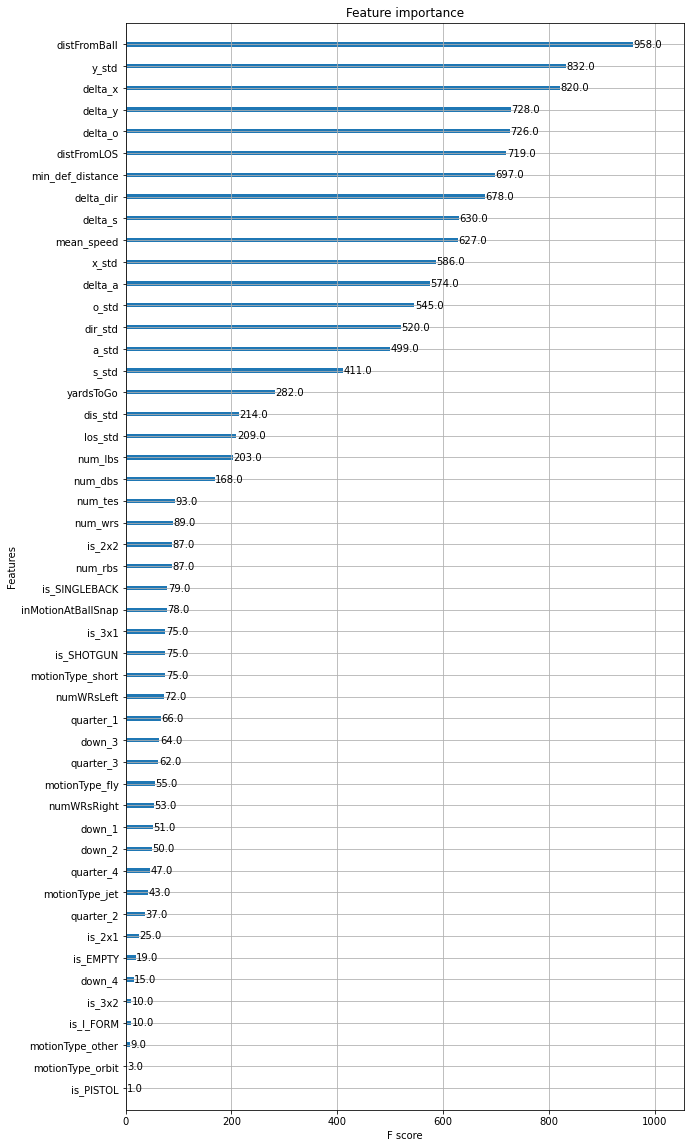

In [55]:
fig, ax = plt.subplots(figsize=(10, 20))
xgboost.plot_importance(XGB_tuned, ax=ax)
plt.show()